In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold, train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings('ignore')

auto_data = pd.read_csv('autos.csv', encoding = 'latin1')
auto_data.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


# 1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

1. dateCrawled - даты обхода 	
2. name - название автомобиля
3. seller - продавец(частный диллер)	
4. offerType -тип предложения	
5. price - цена по объявлению о продаже автомобиля	
6. abtest - техосмотр
7. vehicleType - тип авто	
8. yearOfRegistration - в каком году автомобиль был впервые зарегистрирован
9. gearbox - коробка передач	
10. powerPS - мощность автомобиля в л.с.	
11.	model - модель
12.	kilometer - сколько километров проехал автомобиль
13. monthOfRegistration - в каком месяце автомобиль был впервые зарегистрирован
14. fuelType - тип топлива	
15.	brand - марка
16.	notRepairedDamage - если у автомобиля повреждения, которые еще не       отремонтированы
17. dateCreated - дата создания объявления на ebay	
18.	nrOfPictures - количество картинок в объявлении
19.	postalCode - индекс
20.	lastSeenOnline - когда искатель видел это объявление в последний раз в Интернете

# 2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;

In [4]:
# Созраняем старый набор данных
print('До удаления дубликатов:', auto_data.shape)

До удаления дубликатов: (371528, 20)


In [5]:
# Удаляем дубликаты
auto_data = auto_data.drop_duplicates()
# Удаляем нулевые строки
auto_data = auto_data.dropna()
# Удаляем дублирующиеся под другими названиями признаки
auto_data = auto_data.drop(['dateCrawled', 'name', 'offerType', 'model', 'dateCreated', 'lastSeen', 'postalCode'], axis=1)
print('После удаления дубликатов:', auto_data.shape)

После удаления дубликатов: (260952, 13)


# 3. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

In [6]:
# Разделяем признаки на категориальные и количественные
# Количественные признаки:
quantitative = [column for column in auto_data.columns if auto_data[column].dtype.name != 'object']
print(f"Количественые признаки: {quantitative}")
# Категориальные признаки:
categorical = [column for column in auto_data.columns if auto_data[column].dtype.name == 'object']
print(f"Категориальные признаки: {categorical}")

Количественые признаки: ['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration', 'nrOfPictures']
Категориальные признаки: ['seller', 'abtest', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage']


<AxesSubplot:>

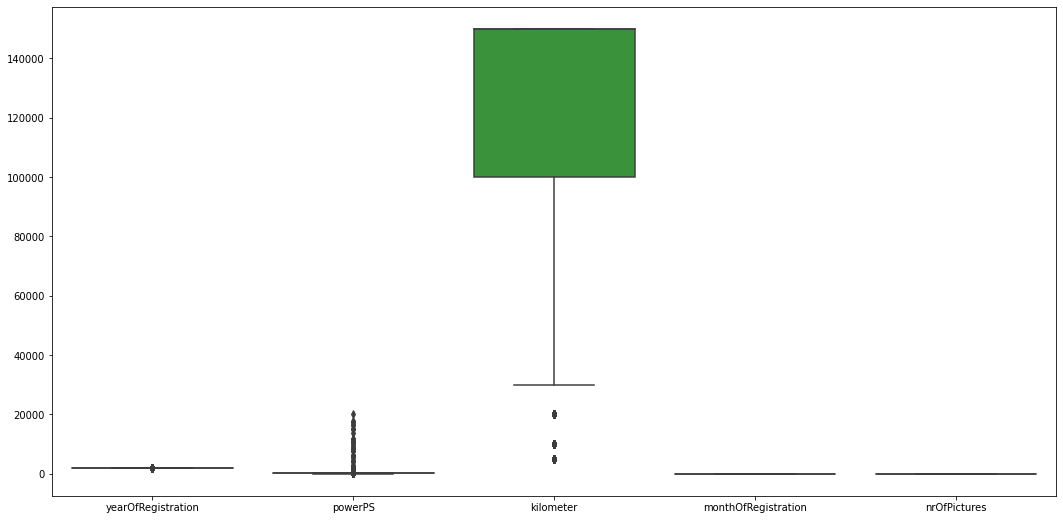

In [7]:
# Диаграмма до мастабирования
# Настройки диаграммы:
# figure - это контейнер самого верхнего уровня. Та область, в которой все нарисовано
# Создаем область figure и указываем ее размер
fig = plt.figure(figsize=(18, 9))
sns.boxplot(data = auto_data[quantitative].drop(['price'], axis = 1))

<AxesSubplot:>

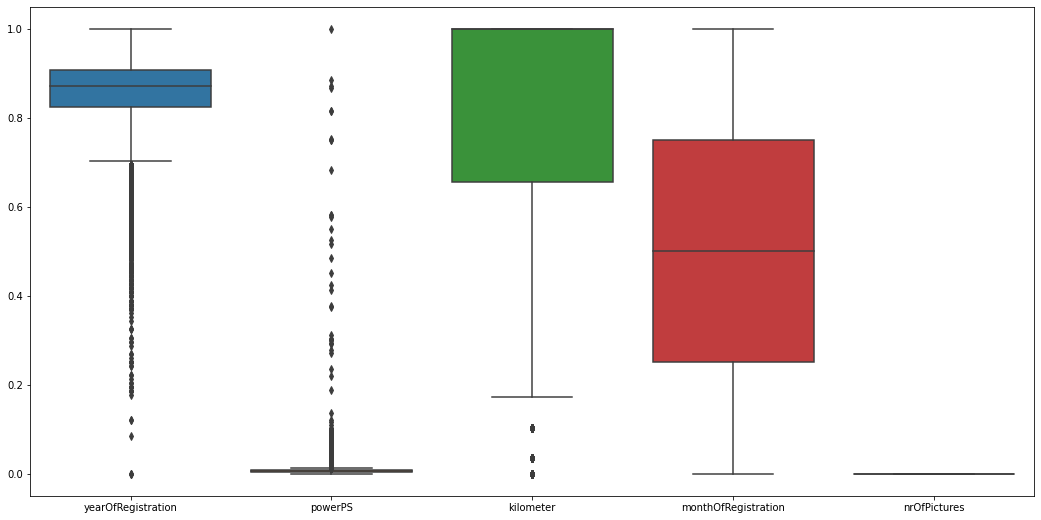

In [8]:
# Производим нормализацию числовых признаков
# Создаем объект класса MinMaxScaler
# Для каждого значения в объекте MinMaxScaler вычитает минимальное значение в объекте и затем делит на диапазон.
# Диапазон - это разница между исходным максимумом и исходным минимумом.
scaler = preprocessing.MinMaxScaler()
# Преобразуем набор данных с помощью функции fit_transform и затем присваиваем измененные данные объекту occupancy
auto_data[['yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration', 'nrOfPictures']] = scaler.fit_transform(auto_data[['yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration', 'nrOfPictures']])
# Cтроим отмастабированную диаграмму
fig = plt.figure(figsize=(18, 9))
sns.boxplot(data = auto_data[['yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration', 'nrOfPictures']])

# 4. Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [9]:
for i in categorical:
    print(i, ': ', auto_data[i].unique())

seller :  ['privat' 'gewerblich']
abtest :  ['test' 'control']
vehicleType :  ['kleinwagen' 'limousine' 'cabrio' 'kombi' 'suv' 'bus' 'coupe' 'andere']
gearbox :  ['manuell' 'automatik']
fuelType :  ['benzin' 'diesel' 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
brand :  ['volkswagen' 'skoda' 'bmw' 'peugeot' 'mazda' 'nissan' 'renault' 'ford'
 'mercedes_benz' 'seat' 'honda' 'fiat' 'mini' 'opel' 'smart' 'audi'
 'alfa_romeo' 'subaru' 'mitsubishi' 'hyundai' 'volvo' 'lancia' 'porsche'
 'citroen' 'toyota' 'kia' 'chevrolet' 'dacia' 'suzuki' 'daihatsu'
 'chrysler' 'jaguar' 'rover' 'jeep' 'saab' 'daewoo' 'land_rover' 'trabant'
 'lada']
notRepairedDamage :  ['nein' 'ja']


In [12]:
# Делим категориальные признаки на бинарные (имеющие два возможных значения)
# и небинарные (имеющие более двух возможных значений)
binary = [i for i in categorical if len(auto_data[i].unique()) == 2]
nonbinary = [i for i in categorical if len(auto_data[i].unique()) > 2]

# Для каждого столбца бинарных признаков заменяем их значения на 0 или 1
for col in binary:
    for i, uniq_item in enumerate(auto_data[col].unique()):
        auto_data[col] = auto_data[col].replace(to_replace = [uniq_item], value = [i])

# Для небинарных признаков:
# 1. С помощью метода get_dummies преобразуем значения небинарных признаков, таким образом, чтобы все их возможные значения выделялись в отдельные столбцы
# И если небинарный признак в данной строке имеет значение, совпадающее с одним из них
# То в этом столбце ставится значение 1, а в противном случае - 0.
auto_nonbinary = pd.get_dummies(auto_data[nonbinary])
# 2. Удаляем все обычные столбцы небинарных признаков из массива данных
auto_data.drop(nonbinary, axis = 1, inplace = True)
# 3. С помощью метода concat включаем в массив данных новые столбцы небинарных признаков, полученные с помощью метода get_dummies
auto_data = pd.concat([auto_nonbinary, auto_data], axis = 1)
auto_data.head()

,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,fuelType_andere,fuelType_benzin,...,seller,price,abtest,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,notRepairedDamage,nrOfPictures
3,0,0,0,0,1,0,0,0,0,1,...,0,1500,0,0.842593,0,0.00375,1.000000,0.500000,0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0,3600,0,0.907407,0,0.00345,0.586207,0.583333,0,0.0
5,0,0,0,0,0,0,1,0,0,1,...,0,650,0,0.787037,0,0.00510,1.000000,0.833333,1,0.0
6,0,0,1,0,0,0,0,0,0,1,...,0,2200,0,0.870370,0,0.00545,1.000000,0.666667,0,0.0
7,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0.648148,0,0.00250,0.241379,0.583333,0,0.0


# 5. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других;

<AxesSubplot:>

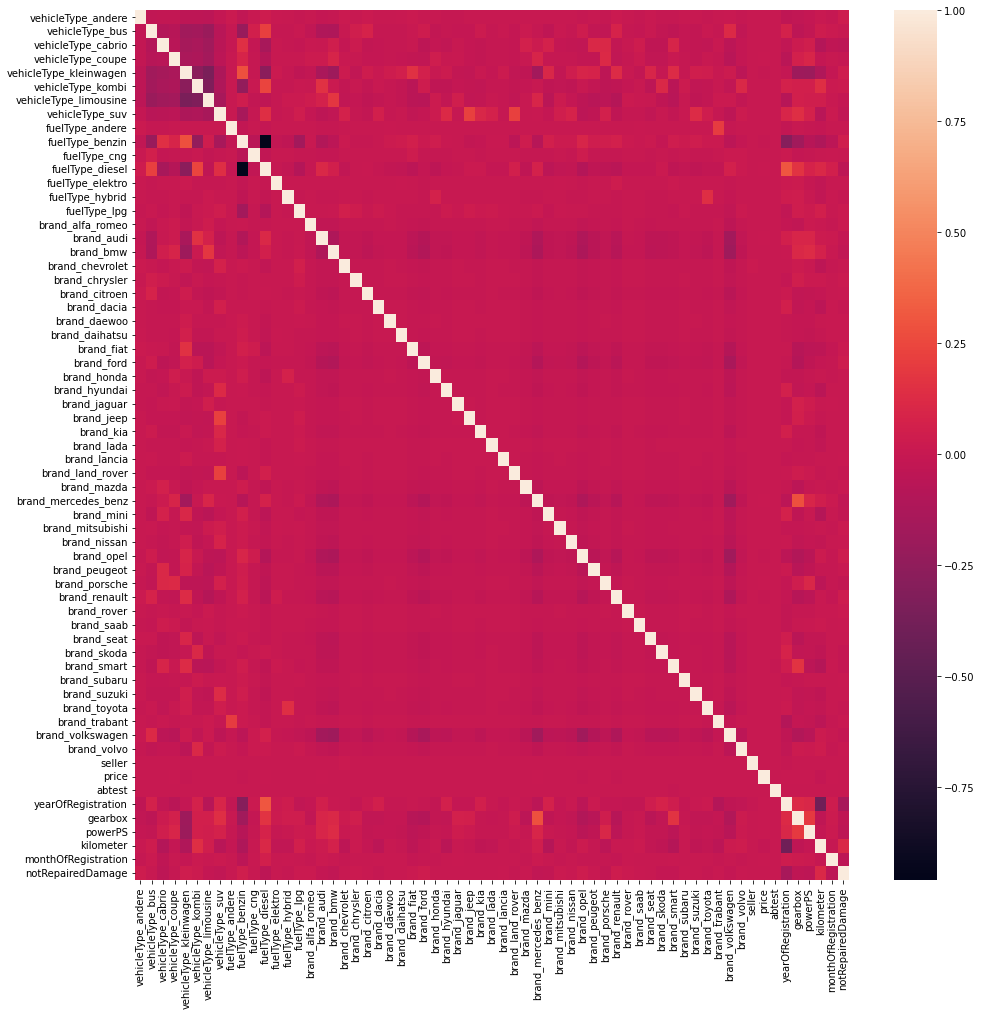

In [14]:
# Находим корреляцию
auto_corr = auto_data.drop('nrOfPictures', axis = 1).corr()
# Строим тепловую карту признаков для оценки корреляции
plt.figure(figsize=(16, 16))
sns.heatmap(auto_corr)

# 6. Заполните пропущенные значения в данных;

In [18]:
# узнаем размер массива (количество строк и столбцов) с помощью метода shape:
auto_data.shape

(260952, 64)

In [19]:
# Подсчитываем количество значений во всех столбцах методом count
auto_data.count()

vehicleType_andere        260952
vehicleType_bus           260952
vehicleType_cabrio        260952
vehicleType_coupe         260952
vehicleType_kleinwagen    260952
                           ...  
powerPS                   260952
kilometer                 260952
monthOfRegistration       260952
notRepairedDamage         260952
nrOfPictures              260952
Length: 64, dtype: int64

Пропущенных значений нет

# 7.	Решите поставленную задачу регрессии в соответствии с заданием. При подборе параметров метода принятия решения (метода регрессии) используйте перекрёстную проверку (изучите возможные для изменения параметры метода регрессии).  Вычислите точность решения задачи, вычислив разницу между реальным значением и предсказанным. Вычислите коэффициент корреляции (Пирсона, Спирмена) между реальным значением и предсказанным с учётом p-value. 

In [20]:
# Наша модель получает в качестве входных значений все признаки автомобиля, кроме цены (X)
# И на ее основе предсказывает выходное значение y, цену автомобиля
X, y = auto_data.drop(['price'], axis=1), auto_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('==============y_test================')
print(y_test)
print('==============X_test================')
print(X_test)
print('==============y_train===============')
print(y_train)
print('==============X_train================')
print(X_train)

==============y_test================
256779    2800
328447    4990
213389     300
200208    7000
353358    2500
          ... 
82571     8000
14322     9200
124488    4500
34743     1150
151708    1800
Name: price, Length: 78286, dtype: int64
==============X_test================
        vehicleType_andere  vehicleType_bus  vehicleType_cabrio  \
256779                   0                0                   0   
328447                   0                1                   0   
213389                   0                1                   0   
200208                   0                0                   0   
353358                   0                0                   0   
...                    ...              ...                 ...   
82571                    0                0                   0   
14322                    0                0                   1   
124488                   0                0                   0   
34743                    0                0       

In [21]:
# Линейная регрессия без использования регуляризаторов
# Создаем модель регрессии
reg = linear_model.LinearRegression()
# Тренируем её
reg.fit(X_train, y_train)
# Предсказываем значения цены автомобиля
pred = reg.predict(X_test)
# Выводим десять значений, полученных вычитанием настоящей цены из предсказанной
print(pred[:10] - y_test[:10])

256779    -4733.3125
328447    14430.3125
213389      728.9375
200208    -7441.6250
353358     -725.5000
183918      -93.7500
69419      7220.6875
72482      2187.8125
349228     2174.8125
128925      812.9375
Name: price, dtype: float64


In [22]:
# Находим корреляцию Пирсона
pearson, p_value_pearson = pearsonr(pred, y_test)
# Находим корреляцию Спирмена
spearman, p_value_spearman = spearmanr(pred, y_test)
print("Корреляция Пирсона: ", pearson)
print("p-value: ", p_value_pearson)
print("Корреляция Спирмена: ", spearman)
print("p-value: ", p_value_spearman)

Корреляция Пирсона:  0.0727324283342039
p-value:  2.6792255333334187e-92
Корреляция Спирмена:  0.6437087361496989
p-value:  0.0


In [27]:
# Линейная регрессия, LASSO регуляризатор
# Подбираем оптимальные параметры для Lasso-регуляризатора
lasso = LassoCV(alphas = np.arange(0.001, 10, 0.05), n_jobs = -1)
# Тренируем модель с целью подбора оптимальных параметров
lasso.fit(X_train, y_train)
# Получаем оптимальный параметр alpha
print('best alpha:', lasso.alpha_)

best alpha: 1.351


In [29]:
# Создаем модель lasoo-регуляризатора
lasso_reg = linear_model.Lasso(alpha=lasso.alpha_)
# Трениурем ее
lasso_reg.fit(X_train, y_train)
# Предсказываем цену автомобиля:
lasso_pred = lasso_reg.predict(X_test)
# Выводим десять значений, полученных вычитанием настоящей цены из предсказанной
print(lasso_pred[:10] - y_test[:10])

256779    -4178.316650
328447    14514.213092
213389      746.177607
200208    -7454.632108
353358     -932.434646
183918      -39.943251
69419      7169.964417
72482      2204.559738
349228     2119.473705
128925      542.177685
Name: price, dtype: float64


In [20]:
# Находим корреляцию Пирсона
pearson, p_value_pearson = pearsonr(lasso_pred, y_test)
# Находим корреляцию Спирмена
spearman, p_value_spearman = spearmanr(lasso_pred, y_test)
print("Корреляция Пирсона: ", pearson)
print("p-value: ", p_value_pearson)
print("Корреляция Спирмена: ", spearman)
print("p-value: ", p_value_spearman)

Корреляция Пирсона:  0.07254881205910103
p-value:  7.673204205993888e-92
Корреляция Спирмена:  0.6417393877888566
p-value:  0.0
